# Linear Tranformation (Scale, Rotate, Reflection, Shear)

In [1]:
from matplotlib.image import imread

import matplotlib.pyplot as plt
import numpy as np

In [2]:
im = imread("assets/cute.jpg")

In [3]:
def extents(T, H, W):
    corners = np.array(((0,0),(0,W-1),(H-1,0),(H-1,W-1)))

    new_corners = np.dot(corners, T).astype(int)
    hmax, wmax = np.max(new_corners, 0)
    hmin, wmin = np.min(new_corners, 0)

    return hmin,wmin,hmax,wmax,hmax-hmin+1,wmax-wmin+1

In [4]:
def transform(im, T):
    T = T.T  # implementation inverted, transpose tranformation matrix
    H, W = im.shape[:2]
    ch = 1 if im.ndim == 2 else 3
    hmin, wmin, hmax, wmax, new_h, new_w = extents(T, H, W)
    
    new_im = np.squeeze(np.zeros((new_h, new_w, ch), dtype=np.uint8))

    YY, XX = np.mgrid[hmin:hmax+1, wmin:wmax+1]
    pts = np.c_[np.ravel(YY), np.ravel(XX)]
    new_pts = np.dot(pts, np.linalg.inv(T)).astype(int)

    valid_idx = np.logical_and(
        np.logical_and(new_pts[:,0]<H, new_pts[:,1]<W),
        np.logical_and(new_pts[:,0]>=0,new_pts[:,1]>=0)
    )
    Y, X = np.hsplit(new_pts[valid_idx], 2)
    Y_, X_ = np.hsplit(pts[valid_idx], 2)
    new_im[Y_-Y_.min(), X_-X_.min()] = im[Y,X]
    return np.squeeze(new_im.reshape(new_h, new_w, -1))

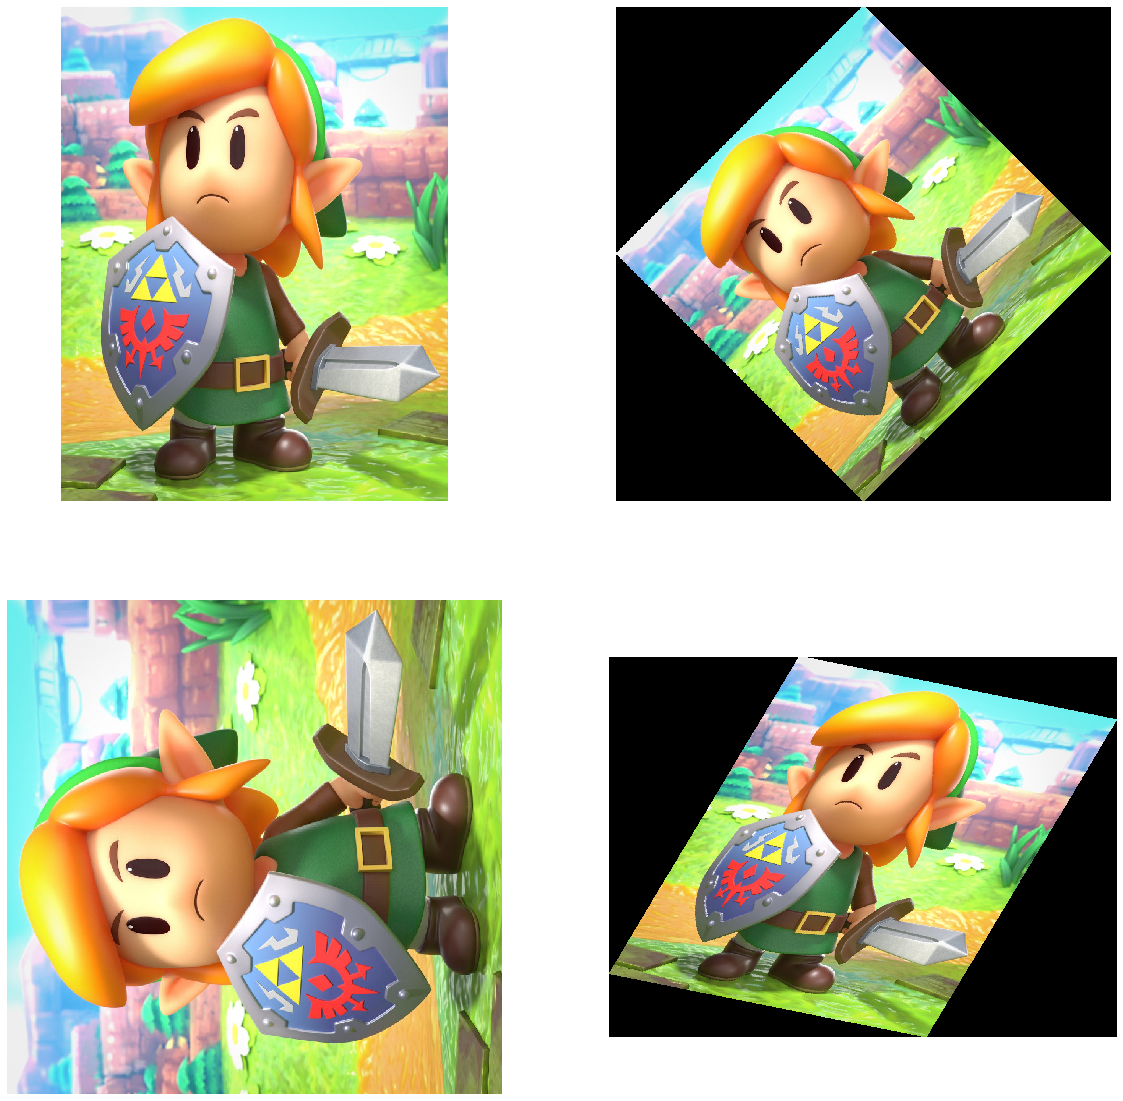

In [5]:
fig = plt.figure(figsize=(20, 20))

# Scaling Matrix
S = np.array(((2.3, 0),(0, 1.8)))

# Rotation Matrix
theta = np.radians(45)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))

# Reflection Matrix
Rf = np.array(((0, -1),(1, 0)))

# Shear Matrix
Sh = np.array(((1, 0.2),(-0.6, 1)))

Ts = [S, R, Rf, Sh]
for i, T in enumerate(Ts,1):
    fig.add_subplot(2, 2, i)
    plt.imshow(transform(im, T), interpolation="nearest")
    plt.axis('off')
plt.show()